In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [25]:
from src.data_loader import ViTDataLoader
from src.vit_train import load_model_dir, ViTTrainer
from src.vit_data import load_cd_data_24x128_p1

model_dir = 'output/cd_fix_24x128_2chan_p1_logfold_20220816_b1f0'

vit, config = load_model_dir(model_dir, legacy=False)
vit_data = load_cd_data_24x128_p1(config.REPLICATE_MODE, config.CHANNEL_1, config.PREDICT_TPM)
config_name = "lfc"

dataloader = ViTDataLoader(vit_data, split_type=config.SPLIT_TYPE, split_arg=config.SPLIT_ARG, 
                           valid_type=config.VALIDATION_TYPE, valid_arg=config.VALIDATION_ARG)
print(dataloader.split_repr())

trainer = ViTTrainer(vit, config_name, dataloader, resume=True, resume_path=model_dir)


Split: time,120; Training: 17708; Validation: 0; Testing: 4427


In [26]:
trainer.setup()

Resuming from 320...


In [332]:
trainer.compute_predictions_losses()

Computing test predictions...Done. 0.656, 0.658
00:01:03.29
Computing train predictions...Done. 0.460, 0.548
00:05:11.67
Computing validation predictions...Done. nan, nan
00:05:11.68


In [ ]:
print(trainer.perf_str)

In [ ]:
trainer.plot_predictions()

In [ ]:
from src.rna_plotter import load_rna_plotter
from src.orf_plotter import ORFAnnotationPlotter

orf_plotter = ORFAnnotationPlotter()
rna_plotter = load_rna_plotter()
trainer.orf_plotter = orf_plotter
trainer.rna_plotter = rna_plotter


In [ ]:
from src.vit_viz import plot_gene_prediction

trainer.plot_gene('HSP26', 7.5)
0

In [ ]:
trainer.plot_gene('HSP26', 120)
0

In [27]:
from src.attention_analysis import AttentionAnalysis

a_analysis = AttentionAnalysis(trainer=trainer)

In [30]:
a_analysis.compute_attentions(t=None)

1/22135 - 00:00:00.26
1001/22135 - 00:03:59.02
2001/22135 - 00:08:33.79
3001/22135 - 00:15:24.23
4001/22135 - 00:20:03.58
5001/22135 - 00:23:49.56
6001/22135 - 00:28:21.19
7001/22135 - 00:32:40.33
8001/22135 - 00:36:51.11
9001/22135 - 00:41:05.58
10001/22135 - 00:45:15.48
11001/22135 - 00:49:26.39
12001/22135 - 00:53:40.68
13001/22135 - 00:57:52.30
14001/22135 - 01:02:11.06
15001/22135 - 01:06:28.38
16001/22135 - 01:27:15.39
17001/22135 - 01:30:58.49
18001/22135 - 01:34:39.03
19001/22135 - 01:38:23.33
20001/22135 - 01:42:08.77
21001/22135 - 01:45:55.63
22001/22135 - 01:49:48.99


In [31]:
from src.utils import write_pickle
write_pickle(a_analysis.trainer.collected_attentions,
            f"{a_analysis.trainer.out_dir}/collected_attentions_all.pkl")

Wrote output/cd_fix_24x128_2chan_p1_logfold_20220816_b1f0/collected_attentions_all.pkl


In [287]:
a_analysis.compute_umap(t=None)

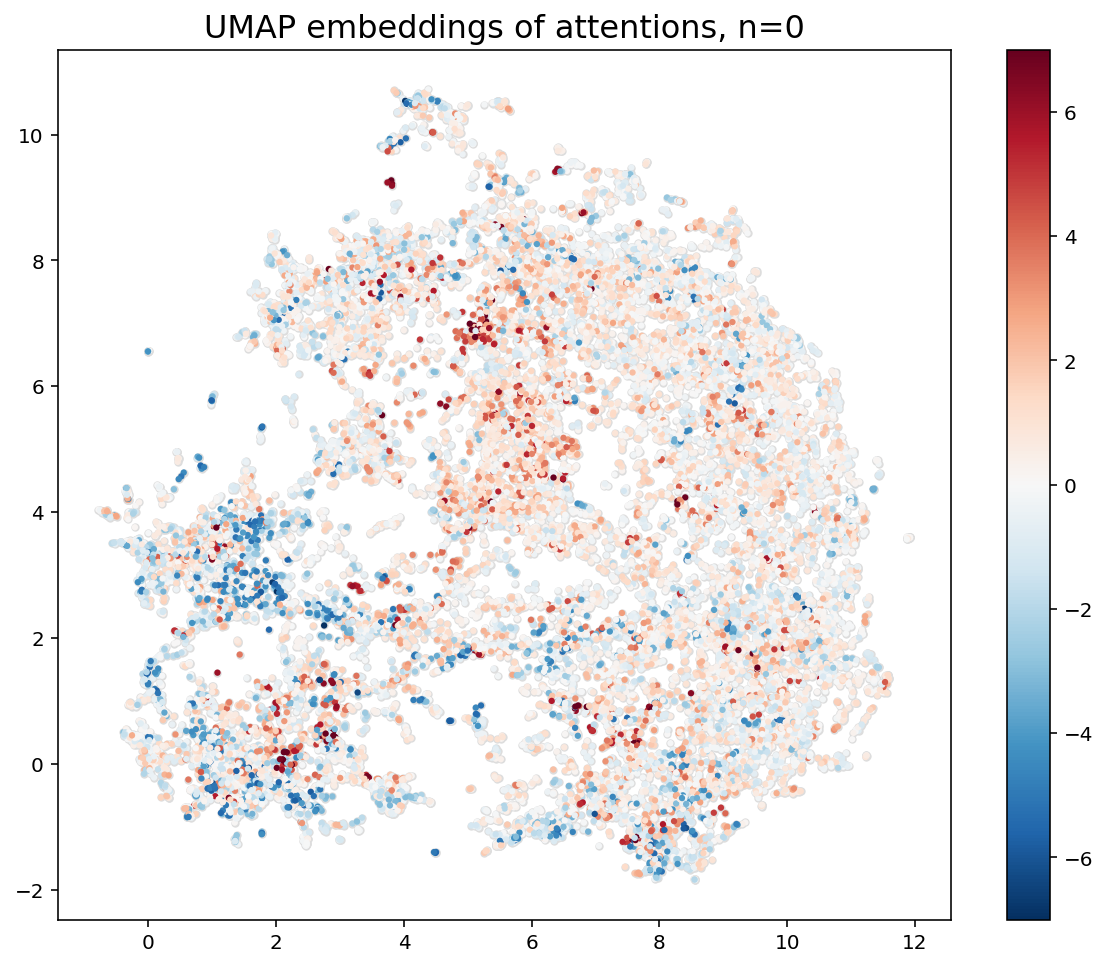

In [288]:
a_analysis.plot_umap(t=None, selected_orfs=[], ascending=None)

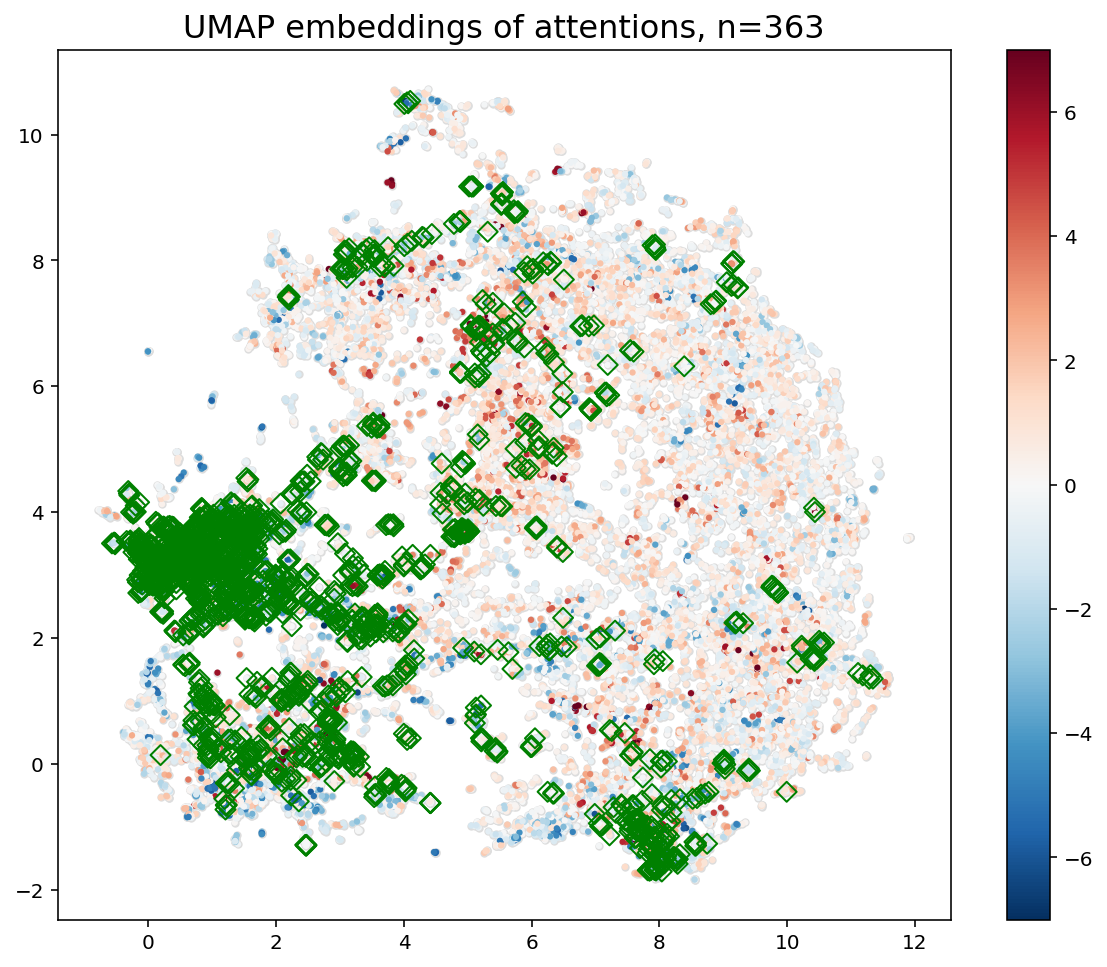

In [293]:
from src.attention_analysis import orfs_for_rossi_tf

a_analysis.load_rossi()
rossi_w_targets = a_analysis.rossi_w_targets

selected_orfs = orfs_for_rossi_tf(vit_data.orfs_data, rossi_w_targets, 'Yta7')

a_analysis.plot_umap(t=None, selected_orfs=selected_orfs)


In [258]:
a_analysis.load_go_terms()

data/go.obo: fmt(1.2) rel(2018-08-29) 47,313 Terms


Term GO:0005625 not found!
Term GO:0004871 not found!
Term GO:0016563 not found!
Term GO:0001950 not found!
Term GO:0030528 not found!
Term GO:0005624 not found!
Term GO:0003709 not found!
Term GO:0000059 not found!
Term GO:0003704 not found!
Term GO:0007109 not found!
Term GO:0006608 not found!
Term GO:0006609 not found!
Term GO:0031015 not found!
Term GO:0000300 not found!
Term GO:0003701 not found!
Term GO:0010843 not found!
Term GO:0005792 not found!
Term GO:0016564 not found!
Term GO:0042991 not found!
Term GO:0003702 not found!
Term GO:0003716 not found!
Term GO:0016565 not found!
Term GO:0030818 not found!
Term GO:0007090 not found!
Term GO:0016944 not found!
Term GO:0000135 not found!
Term GO:0000115 not found!
Term GO:0000299 not found!
Term GO:0004702 not found!
Term GO:0000739 not found!
Term GO:0006200 not found!
Term GO:0004221 not found!
Term GO:0005057 not found!
Term GO:0016566 not found!
Term GO:0051436 not found!
Term GO:0000114 not found!
Term GO:0016585 not found!
T

In [218]:
go_orfs = a_analysis.go_orfs.copy()
go_orfs['n'] = a_analysis.go_orfs.orfs.map(len)
go_orfs

go_gene_max = 1000
go_gene_min = 20
go_lim_terms = go_orfs[(go_orfs.n >= go_gene_min) & (go_orfs.n <= go_gene_max)]

go_dispersions = a_analysis.compute_group_orfs_dispersion(go_lim_terms)

235
0/235 - 00:00:00.09
60/235 - 00:00:00.53
120/235 - 00:00:00.91
180/235 - 00:00:01.28


In [297]:
not_null = go_dispersions.index != 'Null'
go_dispersions.loc[not_null, 'description'] = a_analysis.go_orfs.loc[\
    go_dispersions.loc[not_null].index.values]['description']

cur_terms = go_dispersions[go_dispersions.n > 0]
cur_terms.sort_values('entropy').tail(10)

,js,mean_euclidean,mean_squared_euclidean,n,entropy,entropy_difference,description
GO:0001950,0.123877,2.428303,6.142876,86.0,-54.102011,61.583904,None
GO:0042645,0.158285,2.220400,5.275963,23.0,-53.398133,62.287782,Mitochondrial Nucleoid
GO:0006350,0.180380,2.247347,5.520134,20.0,-52.439002,63.246913,"Transcription, Dna-Templated"
GO:0006950,0.136079,2.347602,5.804234,55.0,-52.408585,63.277331,Response To Stress
GO:0005811,0.151784,2.303769,5.690690,35.0,-51.625212,64.060703,Lipid Droplet
GO:0008361,0.164823,2.185329,5.138344,32.0,-49.409494,66.276421,Regulation Of Cell Size
GO:0009277,0.120219,2.403868,5.967399,86.0,-47.154693,68.531223,Fungal-Type Cell Wall
GO:0005628,0.193793,2.122169,5.007587,25.0,-39.181270,76.504646,Prospore Membrane
GO:0016566,0.169758,2.279465,5.616869,20.0,-34.161315,81.524600,None
GO:0005576,0.173939,2.311824,5.780329,26.0,-25.542025,90.143890,Extracellular Region


In [301]:
orfs_data[orfs_data['name'] == 'HSP26']

,name,chr,start,stop,length,strand,orf_class,ontology,TSS,PAS,half_life,coverage
orf_name,,,,,,,,,,,,
YBR072W,HSP26,2,382030,382674,645,+,Verified,"GO:0003729,GO:0005634,GO:0005737,GO:0006457,GO...",381753,382841.0,137.195,0.999


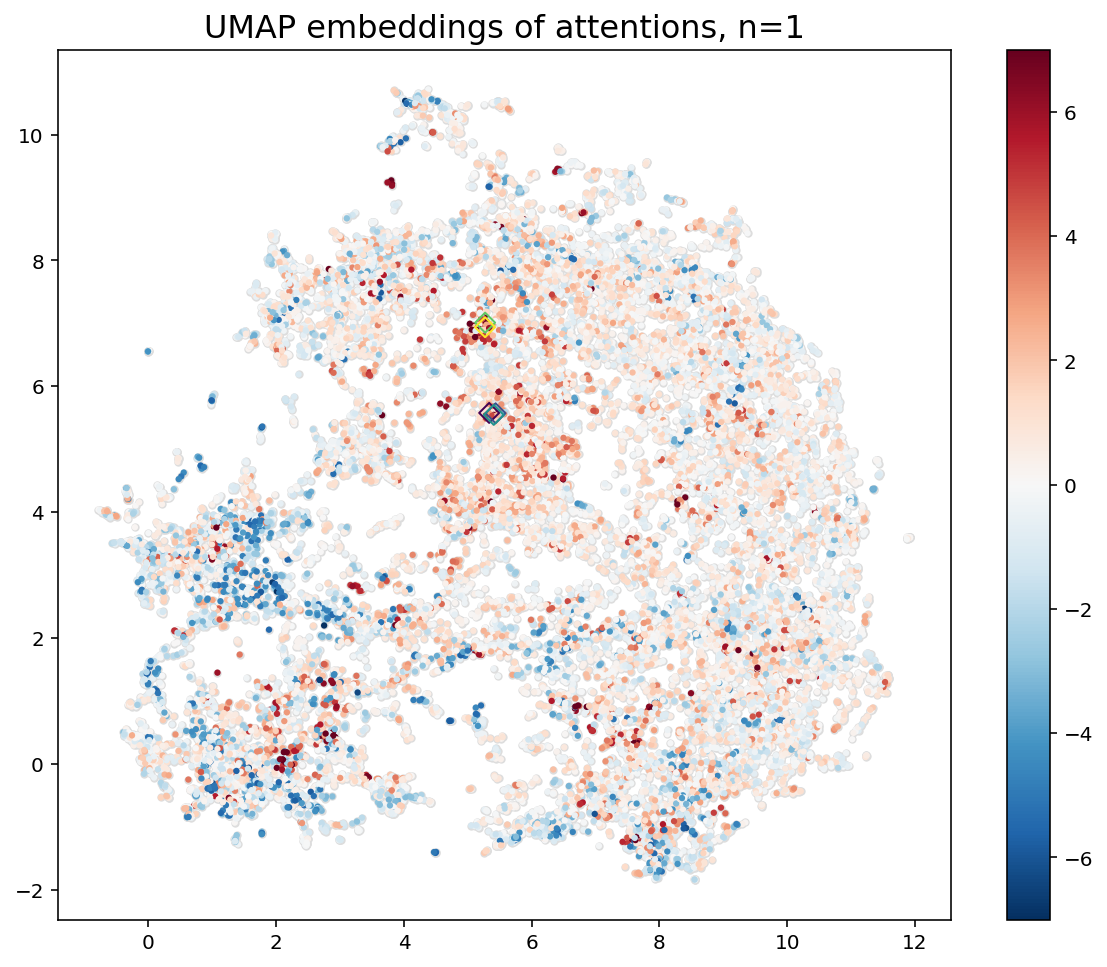

In [327]:
from src.attention_analysis import orfs_for_rossi_tf

#selected_orfs = a_analysis.go_orfs.loc['GO:0016566'].orfs
a_analysis.plot_umap(t=None, selected_orfs=['YBR072W'])


In [323]:

selected_data = a_analysis.embeddings_df.loc['YBR072W']
selected_data

,x,y,tpm_lfc,time
YBR072W,5.334418,5.577415,0.151190,7.5
YBR072W,5.434109,5.572594,5.531108,15.0
YBR072W,5.405983,5.546309,6.661137,30.0
YBR072W,5.271210,7.011540,9.112510,60.0
YBR072W,5.269639,6.938904,11.711861,120.0


In [322]:
selected_data['i'] = np.arange(len(selected_data))/(len(selected_data)-1)
selected_data['color'] = selected_data.i.map(plt.get_cmap('inferno'))
selected_data

,x,y,tpm_lfc,time,i,color
YBR072W,5.334418,5.577415,0.151190,7.5,0.00,"(0.001462, 0.000466, 0.013866, 1.0)"
YBR072W,5.434109,5.572594,5.531108,15.0,0.25,"(0.3415, 0.062325, 0.429425, 1.0)"
YBR072W,5.405983,5.546309,6.661137,30.0,0.50,"(0.735683, 0.215906, 0.330245, 1.0)"
YBR072W,5.271210,7.011540,9.112510,60.0,0.75,"(0.978422, 0.557937, 0.034931, 1.0)"
YBR072W,5.269639,6.938904,11.711861,120.0,1.00,"(0.988362, 0.998364, 0.644924, 1.0)"
